## Line Following with Obstacle Avoidance 

The final task of this week is a combination of the line following and obstacle detection, and wall following behaviors.

The robot should follow the line until an obstacle is detected in its path. Then, the robot will turn and follow the wall at its right until the line is detected again, and it will resume the line following behavior.

PLEASE RUN SIMULATION AT LEAST TWO TIMES, BECAUSE OF RANDOM NOISE SOMETIMES THERE ARE ERRORS

This is the most complex task that we have programmed so far, thus it is a nice candidate for developing with the so-called [**top-down** approach](https://en.wikipedia.org/wiki/Top-down_and_bottom-up_design). With this methodology, we start with a high-level algorithm, and break it down into its components:

    repeat forever
        follow line until an obstacle is detected
        get close to the wall
        follow wall until a line is detected
        get close to the line

### Initialization
First, we need to import all the required modules.

In [52]:
import packages.initialization
import pioneer3dx as p3dx
p3dx.init()
import cv2
import numpy


Found ROS controller /pioneer3dx_30471_ip_172_31_34_222


### Component functions
The first function must return `True` if an obstacle is detected in front of the robot, or `False` otherwise.

In [53]:
def is_obstacle_detected():
    umbral = 0.3
    while min(p3dx.distance[3:5]) > umbral:
        return False
   
    return True    

The second function is the line following with incidences

In [54]:
def line_centroid(image):
    hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
    lower_cyan = numpy.array([130, 100, 0])
    upper_cyan = numpy.array([180, 255, 255])
    lower_green = numpy.array([60, 100, 0])
    upper_green = numpy.array([100, 255, 255])
    #mask = cv2.inRange(hsv, lower_green, upper_green)
    mask = cv2.inRange(hsv, lower_cyan, upper_cyan) 
    mask[0:80, 0:150] = 0
    M = cv2.moments(mask)
    if (M['m00'] == 0):
        cx = -1;
        cy = -1;
        #cgx = 0;
    else:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
    return cx, cy 

def move(V_robot,w_robot):
    r = 0.1953 / 2
    L = 0.33
    w_r = (2 * V_robot + L * w_robot) / (2*r)
    w_l = (2 * V_robot - L * w_robot) / (2*r)
    p3dx.move(w_l, w_r)

def follow_line():
    print('Following the line')
    width = 150
    while not is_obstacle_detected():
        cx, cy = line_centroid(p3dx.image)
        if (cx == -1):            
            #print('lost line')
            p3dx.tilt(-0.20)
            cx, cy = line_centroid(p3dx.image)
            if (cx == -1):
                #print('stop')
                move(0,0)
            else: 
                move(1,0)          
            
        else:
            if is_green_detected():
                hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
                lower_green = numpy.array([60, 100, 0])
                upper_green = numpy.array([90, 255, 255])
                maskg = cv2.inRange(hsv, lower_green, upper_green)
                maskg[0:80, 0:150] = 0
                Mg = cv2.moments(maskg)
                cxg = int(Mg['m10']/Mg['m00'])
                cyg = int(Mg['m01']/Mg['m00'])
                cx, cy = line_centroid(p3dx.image)
                if (cxg < 75):
                    move(0.3,0.6)
                    p3dx.sleep(0.8)                    
                    cx, cy = line_centroid(p3dx.image)
                    if (cx == -1):
                        print('stop')
                        move(0,0)
                    else:
                        move(0.3,0.6)
                        p3dx.sleep(0.8)
                        move(0.3,-0.4)
                        p3dx.sleep(1.6)
                        move(0.3,0.6)
                        p3dx.sleep(1.6)
                    #print('verde menor')
                else:
                    move(0.2,-0.4)
                    p3dx.sleep(1.5)
                    #print('verde mayor')
                #print('verde')             
             
            else:
                p3dx.tilt(-0.47)
                kp = 0.01
                cx, cy = line_centroid(p3dx.image)
                err = cx  - width / 2 
                linear = 0.2
                angular = - kp * err 
                move(linear, angular)
      
    print('Obstacle detected')
    p3dx.move(0,0)

The next function was developed in the previous week: the robot turns until it is approximately parallel to the wall and follow wall.

In [55]:
def getSonars():
    rightSide = min(p3dx.distance[5:])
    frontSide = min(p3dx.distance[3:5])
    leftSide = min(p3dx.distance[:3])
    return rightSide, frontSide, leftSide

MIN_WALL_THRESHOLD = 0.3
MAX_WALL_THRESHOLD = 0.4 

def getWall():
    rightSide, frontSide, leftSide = getSonars()

    while p3dx.distance[0] > MAX_WALL_THRESHOLD:
        yawSpeed = -0.5
        move(0,yawSpeed)
        rightSide, frontSide, leftSide = getSonars()
    move(0,0)

def follow_wall():
    print('Following the wall')
    while not is_line_detected():
        rightSide, frontSide, leftSide = getSonars()
        
        while frontSide > 0.3 and p3dx.distance[0] > 0.2 and p3dx.distance[0] < 0.6:
            move(0.2,0.2)
            if p3dx.distance[0] <= 0.3:
                yawSpeed = -0.2
                move(0,yawSpeed)
            else:
                if p3dx.distance[0] >= 0.6:
                    yawSpeed = 0.3
                    move(0,yawSpeed)
          
    print('Line detected')

The next function is checked during the wall following behavior: it must return `True` when the line is again detected, or `False` otherwise, alse detects green color.

In [56]:
def is_line_detected():
    hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
    lower_cyan = numpy.array([130, 100, 0])
    upper_cyan = numpy.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower_cyan, upper_cyan)
    mask[0:80, 0:150] = 0
    M = cv2.moments(mask)
    if M['m00']==0:
        return False
    else:
        return True
    
def is_green_detected():
    hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
    lower_green = numpy.array([60, 100, 0])
    upper_green = numpy.array([90, 255, 255])
    maskg = cv2.inRange(hsv, lower_green, upper_green)
    maskg[0:80, 0:150] = 0
    Mg = cv2.moments(maskg)
    if Mg['m00']==0:
        return False
    else:
        return True

NEXT THREE ARE NOT NEEDED, JUST FOR CHECKING VISUAL SENSOR

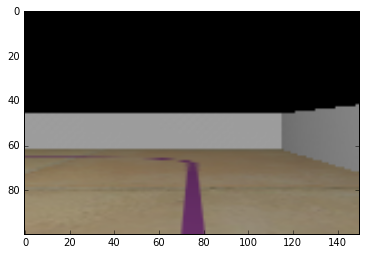

In [57]:
p3dx.tilt(-0.47)
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(p3dx.image);

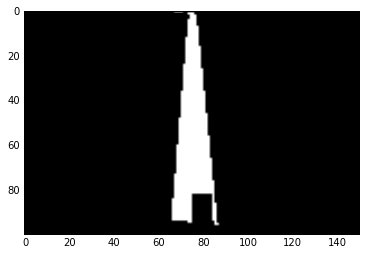

In [58]:
p3dx.tilt(-0.47)
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(p3dx.image);

hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
lower_cyan = numpy.array([130, 100, 0])
upper_cyan = numpy.array([180, 255, 255])
mask = cv2.inRange(hsv, lower_cyan, upper_cyan)
lower_green = numpy.array([60, 100, 0])
upper_green = numpy.array([90, 255, 255])
#mask = cv2.inRange(hsv, lower_green, upper_green)
#mask = cv2.inRange(hsv, lower_cyan, upper_cyan) + cv2.inRange(hsv, lower_green, upper_green)
#mask[0:80, 0:150] = 0
plt.imshow(mask,cmap='gray');


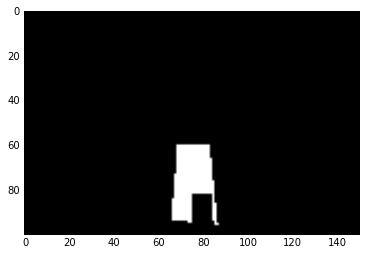

In [59]:
mask[0:60, 0:150] = 0
plt.imshow(mask,cmap='gray');

IMPORTANT, NEXT FUNCTIONS ARE NEEDED
Finally, a function is needed for turning the robot slightly until it is approximately parallel to the line again.

In [60]:
def getLine():
    move(0.1,-1)
    p3dx.sleep(1)
    move(0,0)
    follow_line()

### Main loop
The main loop looks very similar to the proposed algorithm:

In [61]:
p3dx.tilt(-0.47)
try:
    while True:
        follow_line()
        getWall()
        follow_wall()
        getLine()
except KeyboardInterrupt:
    move(0,0)

Following the line
Obstacle detected
Following the wall
Line detected
Following the line
stop


Did it work? Congratulations, you have completed the task of this week!

---
#### Try-a-Bot: an open source guide for robot programming
Developed by:
[![Robotic Intelligence Lab @ UJI](img/logo/robinlab.png "Robotic Intelligence Lab @ UJI")](http://robinlab.uji.es)

Sponsored by:
<table>
<tr>
<td style="border:1px solid #ffffff ;">
<a href="http://www.ieee-ras.org"><img src="img/logo/ras.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="http://www.cyberbotics.com"><img src="img/logo/cyberbotics.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="http://www.theconstructsim.com"><img src="img/logo/theconstruct.png"></a>
</td>
</tr>
</table>

Follow us:
<table>
<tr>
<td style="border:1px solid #ffffff ;">
<a href="https://www.facebook.com/RobotProgrammingNetwork"><img src="img/logo/facebook.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="https://www.youtube.com/user/robotprogrammingnet"><img src="img/logo/youtube.png"></a>
</td>
</tr>
</table>